In [1]:
%matplotlib inline

In [2]:
import itertools
import math
from scipy import stats
import statsmodels.stats.api as sms
from pyspan.AFC.analysis import *
from pyspan import cross_validation as cv
from pyspan.ratings_task.analysis import freq_df, n_utterances, signal_df, SparseLR
from pyspan.utils import *
from pyspan.valence import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13e214410>)

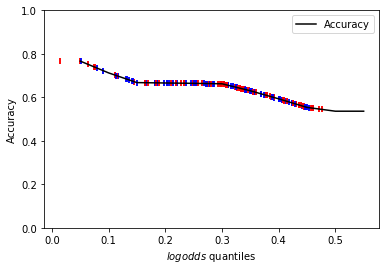

In [3]:
words_ = np.ravel(partisan.loc[p_ixs][["word1","word2"]].values)
cv.plot_("crec", "debates", "word", 
         save = False, words = zip(words_, [-1000] * len(words_), [0] * len(words_)))

Get some descriptive stats.

In [4]:
n = len(minidf)
n_dem = len(minidf[minidf["party"] == "Democrat"])
n_repub = len(minidf[minidf["party"] == "Republican"])
print "N: {}".format(n)
print "N Dem: {}".format(n_dem)
print "N Repub: {}".format(n_repub)

N: 96
N Dem: 50
N Repub: 19


In [5]:
print np.mean(minidf.age[~np.isnan(minidf.age)]), stats.sem(minidf.age[~np.isnan(minidf.age)])
print len(minidf.loc[minidf.gender == 0]), len(minidf.loc[minidf.gender == 1])
print np.mean(minidf.voted)

40.677083333333336 1.1210207198410143
37 59
0.8020833333333334


## Item-level analysis

0.5202876083887881 0.01893722679498896


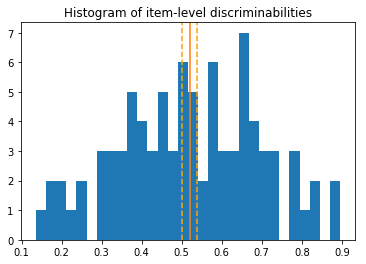

In [6]:
perceps = PerceptualData()
perceps.get_discriminability_by_pair(plot = False)
_, mu, se = histogram(perceps.discrim_by_pair.values(), bins = 30, 
                      title = "Histogram of item-level discriminabilities")
print mu, se

In [7]:
t, p = stats.ttest_1samp(perceps.discrim_by_pair.values(), .5)
t, p / 2

(1.0713083076217071, 0.14351406488368018)

In [8]:
len(perceps.discrim_by_pair.values()) - 1

86

## Individual-level analysis

In [9]:
def get_idv_perceptions(i, ix, _df):
    response = _df.loc[i][str(ix)]
    if isinstance(response, str):
        assert response in partisan.values[ix-1]
        return int(response in truth[_df.loc[i]["Condition"]])
    else:
        return np.nan

In [10]:
prop_correct = []
for i in minidf.index:
    z_idv_perceps = map(lambda ix: get_idv_perceptions(i, ix, minidf), p_ixs)
    z_idv_perceps = np.array(z_idv_perceps)
    z_idv_perceps = z_idv_perceps[~np.isnan(z_idv_perceps)]
    prop_correct.append(sum(z_idv_perceps) / float(len(z_idv_perceps)))

0.5203126392230242 0.006779377332631744


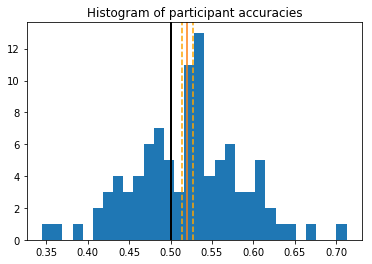

In [11]:
fig, mu, se = histogram(prop_correct, bins = 30, 
                        title = "Histogram of participant accuracies")
ylim = plt.ylim()
plt.ylim(*ylim)
plt.plot([.5,.5], ylim, color = "k", linewidth = 2)

print mu, se

In [12]:
t, p = stats.ttest_1samp(prop_correct, .5)
t, p / 2

(2.996239658360902, 0.0017433022323757033)

In [13]:
len(prop_correct) - 1

95

Is there a significant difference in the discriminability of Democrats and Republicans?

In [14]:
discriminabilities = dict()
for party in ("Democrat", "Republican"):
    pdf = minidf[minidf["party"]==party]

    prop_correct = []
    for i in pdf.index:
        z_idv_perceps = map(lambda ix: get_idv_perceptions(i, ix, pdf), p_ixs)
        z_idv_perceps = np.array(z_idv_perceps)
        z_idv_perceps = z_idv_perceps[~np.isnan(z_idv_perceps)]
        prop_correct.append(sum(z_idv_perceps) / float(len(z_idv_perceps)))
    discriminabilities[party] = prop_correct

In [15]:
d, r = discriminabilities["Democrat"], discriminabilities["Republican"]

print "Mean discriminability for Democrats: %f (SE: %f)"%(np.mean(d), stats.sem(d))
print "Mean discriminability for Republicans: %f (SE: %f)"%(np.mean(r), stats.sem(r))
print "\n"

cm = sms.CompareMeans(sms.DescrStatsW(d), sms.DescrStatsW(r))
tstat, pvalue, deg_freedom = cm.ttest_ind(usevar="unequal")
print "T-stat: %f"%tstat
print "P value: %f"%pvalue
print "Degrees of freedom: %f"%deg_freedom

Mean discriminability for Democrats: 0.508276 (SE: 0.009302)
Mean discriminability for Republicans: 0.534469 (SE: 0.015246)


T-stat: -1.466555
P value: 0.152180
Degrees of freedom: 32.252885


Appendix: Analysis of hypothesized mediators

In [16]:
signal_df = pickle.load(open(paths["metrics_dir"] + "signals-unigrams", "rb"))

def get_signal(w):
    dlogp, rlogp = signal_df.loc[w]["dmetric"], signal_df.loc[w]["rmetric"]
    assert dlogp * rlogp < 0
    return dlogp, rlogp

signals_ = map(get_signal, itertools.chain(*partisan_pairs))
signals = dict(zip(itertools.chain(*partisan_pairs), signals_))

In [17]:
lr_data = minidf.copy()
lr_data = lr_data.loc[lr_data.party.isin([ "Democrat", "Republican" ])]
n = len(lr_data)
partisan_pairs = np.array(partisan_pairs)
n_vars = 9

# Add dummy columns
for i in range(1, n):
    ids = np.zeros(n)
    ids[i] = 1
    lr_data["participant{}".format(i)] = ids
    
w1 = np.ravel(lr_data[map(str, p_ixs)])
w2 = w1.copy()
for pair in partisan_pairs:
    w2[w2 == pair[0]] = "TMP"
    w2[w2 == pair[1]] = pair[0]
    w2[w2 == "TMP"] = pair[1]
    
X = np.full((n * len(p_ixs), n_vars + n - 1), np.nan)
# The log odds that the word was said by a Republican
vf = np.vectorize(lambda w1_, w2_: signals[w1_][0] + signals[w2_][1])
X[:,0] = np.tile(vf(partisan_pairs[:,0], partisan_pairs[:,1]), n)
# The log probability of hearing the word
vf = np.vectorize(lambda w1_, w2_: math.log(sum(freq_df.loc[(w1_,["dmetric","rmetric"])].values) / n_utterances, 2) +
                                   math.log(sum(freq_df.loc[(w2_,["dmetric","rmetric"])].values) / n_utterances, 2))
X[:,1] = np.tile(vf(partisan_pairs[:,0], partisan_pairs[:,1]), n)
# Participant's political identity
vf = np.vectorize(lambda pid: 1 if pid == "Republican" else -1 if pid == "Democrat" else 
                  0)
pids = np.repeat(vf(lr_data.party), len(p_ixs))
X[:,2] = pids
# Valence of word
vf = np.vectorize(lambda w1_, w2_: get_valence(w1_)[0]-5 - (get_valence(w2_)[0]-5))
X[:,3] = vf(*np.array(zip(w1, w2)).T)
# Valence of word * Participant's party identity * Polarity
sign = np.vectorize(lambda w: np.sign(signal_df.loc[w].rmetric) if not is_nan(w) else np.nan)
X[:,4] = pids * X[:,3] * sign(w1)
# Party identity
X[:,5] = np.repeat(lr_data.party_identity, len(p_ixs))
# Party affiliation x party identity
X[:,6] = pids * X[:,5]
# Political engagement
X[:,7] = np.repeat(lr_data.political_engagement, len(p_ixs))
# Party affiliation x political engagement
X[:,8] = pids * X[:,7]
# Participant IDs
for i in range(n_vars, n_vars + n - 1):
    X[:,i] = np.repeat(lr_data["participant{}".format(i-n_vars+1)], len(p_ixs))

condition = np.repeat(lr_data.Condition, len(p_ixs))
condition[condition == "DEMOCRAT"] = -1
condition[condition == "REPUBLICAN"] = 1
Y = sign(w1) == condition

X = X[~np.isnan(Y)]
Y = Y[~np.isnan(Y)]
Y = Y[~np.isnan(X).any(axis = 1)]
X = X[~np.isnan(X).any(axis = 1),:]
X = stats.mstats.zscore(X)

In [18]:
logit = SparseLR(Y, X)
logit.coef[:n_vars], logit.n, logit.auc

/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


(array([0.00407138, 0.        , 0.        , 0.        , 0.20110851,
        0.        , 0.        , 0.        , 0.        ]),
 5381,
 0.5838467170068711)